Q函数接收一个状态并生成状态-动作-价值（Q值），然后策略函数使用该值生成一个动作。也可以直接训练一个策略函数，以处理一个状态并返回动作的概率分布。

领域Q-learning或子空间Q-learning:承认在大多数环境中，只有彼此接近的智能体才会对彼此产生较大的影响。我们不必模拟环境中所有智能体的联合动作，而是通过仅模拟相同领域内的智能体的联合动作来近似，在某种意义上，我们将整个联合动作空间分成一组重叠的子空间，而仅仅计算这些小得多多子空间多Q值。可以称这种算法为领域Q-learning或子空间Q-learning。

每个智能体都有一个视场或领域，他只能看到该领域内其他智能体的动作，但是仍然可以获得环境的完整状态信息。

智能体 j 的领域Q 函数接收当前状态和领域（或视场）内其他智能体的联合动作向量$a_{-j}$。他会产生要传递到策略函数的Q 值，而策略函数会选择要采取的动作。

一维伊辛模型：创建网格并产生奖励

一下代码包含两个函数，第一个函数通过创建一个由呈标准正态分布的数字组成的网格来创建一个随机初始化的一维网格（向量）。然后将所有的非正数设置为 0，将所有正数设置为 1，结果将在网格中得到数量基本相同的 1 和 0.

第二个函数是奖励函数，用于接收一个二进制的列表 s 和一个二进制数 a，然后比较 s 中又多少个值与a 匹配，如果所有值都匹配，则奖励为最大值，如果都不匹配，则奖励为负。输入 s 将是邻居的列表。

In [44]:
import numpy as np
import torch
from matplotlib import pyplot as plt

#初始化多智能体环境
def init_grid(size=(10,)):
    #*size 是解包操作，将元组 size 中的元素作为参数传递给 torch.randn 函数。
    grid = torch.randn(*size)
    grid[grid > 0] = 1
    grid[grid <= 0] = 0
    grid = grid.byte() #将浮点数转换为字节对象使其二进制化
    return grid

#计算奖励
def get_reward(s,a): #此函数接收s中的邻居，并将他们与智能体a比较，如果匹配，则奖励就会更高。
    r = -1
    for i in s:
        if i == a:
            r += 0.9
    r *= 2.
    return r

In [45]:
size=(20,)
grid=init_grid(size=size)
grid

tensor([0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0],
       dtype=torch.uint8)

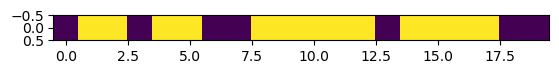

In [46]:
#np.expand_dims 是 NumPy 库中的一个函数，用于在数组的指定位置插入新的轴来扩展数组的维度
plt.imshow(np.expand_dims(grid,0))

一维伊辛模型：生成神经网络参数

由于我们将用一个神经网络来模拟Q 函数，因此需要为他生成参数。

In [47]:
def gen_params(N,size): #此函数为神经网络生成一个参数向量列表
    ret = []  #存储生成的参数向量
    for i in range(N):
        #torch.randn(size) ：生成标准正态分布的随机数
        #/ 10. ：将参数值缩小10倍，使初始值较小
        vec = torch.randn(size) / 10.
        vec.requires_grad = True
        ret.append(vec)
    return ret

一维伊辛模型：定义Q 函数

由于一维伊辛模型非常简单，我们将通过指定所有的矩阵乘法来手动编写神经网络，而非使用 pytorch 内置的层。我们需要创建一个Q 函数，用于接收一个状态向量和一个参数向量，并将参数向量分解成多个矩阵，以形成神经网络的每一层。

 这是用简单的两层神经网络实现的Q 函数，他需要一个状态向量 s（邻居状态的二进制向量）和一个参数向量 theta，他还需要关键字参数 layers，这是一个[(s1,s2),(s3,s4)...]形状的列表，表示各层参数矩阵的形状。所有的Q 函数都会返回每个可能动作的Q 值。

 智能体 j 的Q 函数接收一个参数向量和一个独热编码的智能体 j 的邻居联合动作向量。

 使用单参数向量的优势是：可以很容易的将多个神经网络的所有参数存储为一个向量列表。我们只需让神经网络将向量分解为层矩阵。之所以用 tanh 激活函数，是因为他的输出范围是[-1,1]，而我们的奖励处于区间[-2,2]，所以+2奖励将强烈的将Q 值输出推向+1.然而我们希望能够在后续项目中复用这个Q 函数，所以将激活函数作为一个可选的关键字参数 afn 来提供。

In [48]:
#多智能体强化学习中动作价值计算
def qfunc(s,theta,layers=[(4,20),(20,2)],afn=torch.tanh):
    l1n = layers[0]   #获取第一层维度（输入 4，隐藏 20）
    #np.prod 是 NumPy 库提供的用于计算数组元素乘积的函数
    l1s = np.prod(l1n) #取layers中的第一个元组，将这些数相乘以获得theta向量的子集，并将其用作神经网络的第一层
    theta_1 = theta[0:l1s].reshape(l1n) #将theta 向量子集重塑为一个矩阵，以用作神经网络的第一层
    l2n = layers[1]
    l2s = np.prod(l2n)
    theta_2 = theta[l1s:l2s+l1s].reshape(l2n)
    #网络前向传播
    bias = torch.ones((1,theta_1.shape[1]))
    l1 = s @ theta_1 + bias #这是第一层计算，其中输入 s 是一个维度为（4,1）的联合动作向量
    l1 = torch.nn.functional.elu(l1)  # ELU激活函数
    l2 = afn(l1 @ theta_2) #我们也可以输入一个激活函数用于最后一层，默认的是 tanh，因为我们的奖励范围是[-1,1]
    return l2.flatten()  # 展平输出为动作价值向量

一维伊辛模型：产生环境的状态信息

以下代码的函数是为Q 函数准备状态信息所需要的两个辅助函数。get-substate 函数接收一个二进制数（0 表示自旋向下 ，1 表示自旋向上），并将其转换为一个独热编码的动作向量，其中 0 变成动作空间[向下，向上]中的[1,0],1 变成[0,1]。网格只包含一系列代表每个智能体自旋方向的二进制数，但我们需要将这些二进制数转换为动作向量，然后通过求其外积来得到Q 函数的联合动作向量。

In [49]:
def get_substate(b): #取一个二进制数，并将其转换成一个类似于[0,1]的独热编码的动作向量
    s = torch.zeros(2)  #存储转换后的独热编码动作向量。
    if b > 0: #如果输入为 0(向下)，那么动作向量为[1,0]，否则为[0,1]
        s[1] = 1
    else:
        s[0] = 1
    return s

def joint_state(s): #s是一个包含两个元素的向量，其中s[0]=左邻居，s[1]=右邻居
    s1_ = get_substate(s[0]) #获取s中每个元素的动作向量
    s2_ = get_substate(s[1])
    ret = (s1_.reshape(2,1) @ s2_.reshape(1,2)).flatten() #使用外积创建联合动作空间，然后展平成一个向量
    return ret

一维伊辛模型：初始化网格

tensor([0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0],
       dtype=torch.uint8)


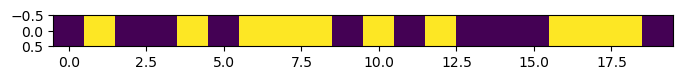

In [50]:
plt.figure(figsize=(8,5))
size = (20,) #将网格的总大小设置为一个长度为 20 的向量
hid_layer = 20 #设置隐藏层的大小。本例中的Q 函数是一个两层神经网络，所以只有一个隐藏层
params = gen_params(size[0],4*hid_layer+hid_layer*2) #生成一个将参数化Q 函数的参数向量列表
grid = init_grid(size=size)
grid_ = grid.clone() #复制网格（原因将在主训练循环中变得清晰）
print(grid)
#expand_dims：在数组的指定位置插入新的轴，从而扩展数组的维度。np.expand_dims 只是增加了数组的维度，并没有改变数组的数据内容
#matplotlib 库中的 imshow 函数，用于将数组作为图像显示。
plt.imshow(np.expand_dims(grid,0))

一维伊辛模型：主训练循环

在主训练循环中，遍历所有 20 个智能体。找到每个智能体的左邻居和右邻居，获取他们的联合动作向量，并据次来计算自旋向下和自旋向上这两种可能动作的Q 值。我们建立的一维伊辛模型是一个环形网格，所有智能体都有一个左邻居和一个右邻居。

每个智能体都有各自用于参数化Q 函数的相关参数向量，所以每个智能体都由一个单独的深度Q 网络控制。同样由于每个智能体都有相同的最优策略，即与其邻居以相同的方式对齐，因此可以使用单个DQN 来控制所有智能体。我们将在后续项目中使用这种方法，但展示单独建模每个智能体的简易性是很有必要的。在其他环境中，智能体可能有不同的最优策略，此时需要为每个智能体使用单独的DQN。

我们简化了主训练循环，以避免干扰。首先，我们使用的策略是$\epsilon$贪婪策略。因为不存在有时采取随机动作的$\epsilon$贪婪策略，智能体每次会采取Q 值最高的动作。通常情况下，某种类型的探索策略是必要的，但由于这是一个非常简单的问题，因此模型仍然能够正常工作。

主训练循环：对于每个智能体 j，对应 Q 函数接收一个参数向量和智能体 j 的联合动作向量（表示为$a_{-j}$），并输出一个包含两个元素的 Q 值向量作为策略函数的输入。策略函数选择一个动作（一个二进制数），然后将其存储在网格环境的镜像（副本）中。所有智能体都选择了动作后，网格环境的镜像将与主网格同步。然后主网格生成每个智能体的奖励并将其传递给损失函数，由损失函数计算损失并将其反向传播给 Q 函数，最终进入参数向量进行更新。

In [51]:
epochs = 200
lr = 0.001 
#每个智能体独立记录损失
losses = [[] for i in range(size[0])] #由于我们要处理多个智能体，而每个智能体由一个单独的Q 函数控制，因此必须跟着多个损失
for i in range(epochs):
    for j in range(size[0]): #遍历每个智能体
        l = j - 1 if j - 1 >= 0 else size[0]-1 #获取左邻居，如果处于开头，则循环到末尾
        r = j + 1 if j + 1 < size[0] else 0 #获取右邻居，如果处于末尾，则循环到开头
        state_ = grid[[l,r]] #state_是两个二进制数，分别表示左邻域和右邻域的自旋
        state = joint_state(state_) #state 是由两个二进制数（代表两个智能体的动作）组成的向量，将其转换成一个独热联合动作向量
        #detach()：将 state 张量从计算图中分离出来，得到一个新的张量。分离后的张量不会再参与梯度的计算，在后续的反向传播过程中不会对 state 进行梯度更新
        qvals = qfunc(state.float().detach(),params[j],layers=[(4,hid_layer),(hid_layer,2)])
        qmax = torch.argmax(qvals,dim=0).detach().item() #策略是采取与最高Q 值相关联的动作
        action = int(qmax)
        grid_[j] = action #将动作存入网格的临时副本grid_中，只有所有智能体都执行了动作，才将他们复制到主网格中
        reward = get_reward(state_.detach(),action)
        with torch.no_grad(): 
            target = qvals.clone()  #target值是Q 值向量，将其中采取的动作关联的Q 值替换成观察奖励
            target[action] = reward
        loss = torch.sum(torch.pow(qvals - target,2))  #MSE 损失
        losses[j].append(loss.detach().numpy())
        loss.backward()
        with torch.no_grad(): #手动梯度下降
            params[j] = params[j] - lr * params[j].grad
        params[j].requires_grad = True  #重置梯度状态
    with torch.no_grad(): #将临时网格的内容复制到主网格向量中
        grid.data = grid_.data  #把临时网格 grid_ 中的动作信息复制到主网格 grid 中

绘制网格：

以下代码运行图（上面的图）是每个智能体在每个轮次的损失的散点图（每个颜色代表一个不同的智能体）。可以看到，所有损失都下降并稳定在大概 30 个轮次处。运行图（下面的图）是伊辛模型网格，可以看到，电子已经聚集成两个完全对齐的域。中间颜色较浅的部分是一组按向上（1）方向对齐的智能体，其余的则按向下（0）方向对齐。则比开始时使用的随机分布要好得多，所以一维MARL 算法在一维伊辛模型中肯定起了作用

运行图（上面的图）每个智能体随着训练轮次变化的损失。可以看到他们都在减小且大约稳定在 30 个轮次处。运行图（下面的图）最大化奖励（最小化能量）后的一维伊辛模型。可以看到所有电子聚集在一起形成域，域中他们的自旋方向完全一致。

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
       dtype=torch.uint8) tensor(8)


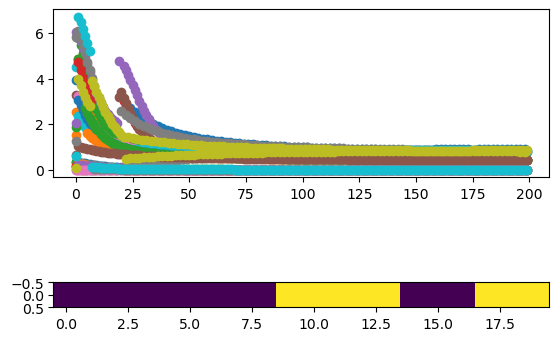

In [52]:
fig,ax = plt.subplots(2,1)
for i in range(size[0]):
    ax[0].scatter(np.arange(len(losses[i])),losses[i])
print(grid,grid.sum())
ax[1].imshow(np.expand_dims(grid,0))

二维伊辛模型：我们将二维伊辛模型表示为一个二维正方形网格（矩阵），这样设计模型中就不存在边界，因此看起来在边界上的智能体实际上与网格对侧的智能体相邻。因此二维网格实际上是一个包裹在球体表面的二维网格。

平均场Q-learning 在二维伊辛模型工作：二维伊辛模型除了一个二维网格（矩阵），其他方面与一维版本的完全相同。网格实际上包裹在一个球体表面。

用于二维伊辛模型的第一个新函数是 softmax 函数。

softmax 函数在数学上的定义：$P_{t}(a)=\frac{exp(\frac{q_{t}(a)}{\tau})}{\sum_{i=1}^{n}exp \frac{q_{t}(a)}{\tau}}$

In [53]:
from collections import deque #使用双端队列数据结构作为经验回放存储列表，因为他可以设置最大容量
from random import shuffle #使用shuffle函数将经验回放缓冲器中的内容随机排序

#temp：温度参数，控制softmax分布的平滑程度，较高的温度会使分布更加平滑，动作选择更加随机；较低的温度会使分布更加集中，动作选择更加倾向于Q值较高的动作
def softmax_policy(qvals,temp=0.9): #这个策略函数接收一个Q值向量并返回一个动作 0（向下）或 1（向上）
    soft = torch.exp(qvals/temp) / torch.sum(torch.exp(qvals/temp)) #softmax 函数 的定义
    #1 表示要选择的元素数量，这里选择 1 个动作
    action = torch.multinomial(soft,1) #softmax 函数将 Q 值转换为一个动作的概率分布。使用 multinomial 函数随机选择一个概率加权的动作
    return action

平均场Q-learning：坐标和奖励函数

由于在二维网格中使用[x,y]坐标索引智能体不方便，因此通常将二维网格扁平化为一个向量来使用单个索引值检索智能体，但需要能将这个扁平化的索引转换为[x,y]坐标，这就是get_coords 函数所实现的功能。get_reward_2d 是用于二维网格的新奖励函数，可用于会计算动作向量与平均场向量之间的差异。

In [54]:
def get_coords(grid,j): #接收扁平网格中的单个索引值，并将其转换会[x,y]坐标
    #np.floor：numpy 库中的 floor 函数，用于向下取整，将行号转换为整数
    x = int(np.floor(j / grid.shape[0])) #获取x坐标
    y = int(j - x * grid.shape[0]) #获取y坐标
    return x,y

def get_reward_2d(action,action_mean): #二维网格的奖励函数
    r = (action*(action_mean-action/2)).sum()/action.sum() #奖励基于动作和平均场动作的差异程度生成
    return torch.tanh(5 * r) #使用tanh函数将奖励缩放到[-1,+1]内

In [55]:
x1 = get_reward_2d(torch.Tensor([1,0]),torch.Tensor([0.25, 0.75]))
x2 = get_reward_2d(torch.Tensor([0,1]),torch.Tensor([0.25, 0.75]))
print(x1,x2)

tensor(-0.8483) tensor(0.8483)


平均场Q-learning：计算平均场动作向量

以下代码将接收一个智能体索引 j（单个整数，基于扁平网格的索引），并返回网格上该智能体最邻近（周围）的 8 个智能体的平均动作。我们通过获取智能体的坐标来找到 8 个最邻近的智能体，然后将每个[x,y]组合相加。

In [56]:
def mean_action(grid,j):
    x,y = get_coords(grid,j) #将向量化索引 j 转换为网格坐标[x,y],其中[0,0]表示左上角
    action_mean = torch.zeros(2) #这就是我们要增加的动作均值向量
    for i in [-1,0,1]: #两个for 循环可用于找到距离智能体 j 最近的八个邻居
        for k in [-1,0,1]:
            if i == k == 0:  #跳过当前位置本身
                continue
            x_,y_ = x + i, y + k
            x_ = x_ if x_ >= 0 else grid.shape[0] - 1
            y_ = y_ if y_ >= 0 else grid.shape[1] - 1
            x_ = x_ if x_ <  grid.shape[0] else 0
            y_ = y_ if y_ < grid.shape[1] else 0
            cur_n = grid[x_,y_]
            s = get_substate(cur_n) #将每个邻居的二进制自旋转换为一个动作向量
            action_mean += s  #将邻居的子状态累加到 action_mean 向量上
    action_mean /= action_mean.sum() #将动作向量归一化为一个概率分布
    return action_mean

这是一个随机初始化的二维伊辛模型。其中，每个方格代表一个电子，浅色方格代表自旋向上的电子，深色方格代表自旋向下的电子

tensor(58)


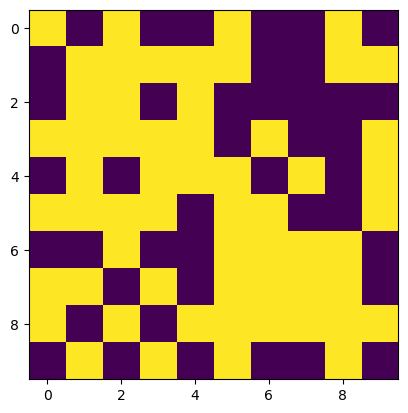

In [57]:
size = (10,10)
#np.prod(size)计算size元组中元素的乘积，也就是网格中元素的总数。对于 size = (10, 10)，J 的值为 10 * 10 = 100
J = np.prod(size)  #np.prod 是 numpy 库中的函数，用于计算数组元素的乘积
hid_layer = 10  #神经网络隐藏层的神经元数量
layers = [(2,hid_layer),(hid_layer,2)]
#第一个参数 1 表示生成参数的随机种子或生成方式
#第二个参数 40 是总参数维度
params = gen_params(1,2*hid_layer+hid_layer*2)
grid = init_grid(size=size)
grid_ = grid.clone()
grid__ = grid.clone()
plt.imshow(grid)
print(grid.sum())

平均场Q-learning:主训练循环

 虽然代码很长，但只比一维伊辛模型稍微复杂一点。首先要指出的是，由于每个智能体的平常场依赖于他的邻居，而邻居的自旋是随机初始化的，因此一开始所有的平均场也是随机值。为了帮助收敛，我们首先允许每个智能体基于这些随机平均场选择一个动作，并将该动作存储在临时网格副本grid_中，以便在所有智能体做出采取那个动作的最终决定之前，主网格保持不变。每个智能体在 grid_中做出尝试性动作之后，我们就更新第二个临时网格副本grid_，并使用他来计算平均场。在下一个迭代中，平均场将会改变，我们将运行智能体更新他们的试验性动作。这样重复几次（由num_iter 参数控制决定重复次数），以允许动作根据Q 函数的当前版本稳定在最优值附近。然后更新主网格并收集所有动作、奖励、平均场和q_next 值（$V(S_{t+1})$），并将他们添加到经验回放缓冲器。

一旦回放缓冲器中的经验值数量大于批大小参数，我们就可以开始在小批量经验上进行训练。我们生成一个随机索引值列表，并用其获取回放缓冲器中一些随机经验的子集。然后像往常一样运行一步梯度下降

In [58]:
epochs = 75
lr = 0.0001
num_iter = 3 #num_iter决定了需要迭代多少次来消除平均场动作的初始随机性
losses = [ [] for i in range(size[0])] #创建一个列表，以存储每个智能体的损失
replay_size = 50 #replay_size决定了我们在经验回放列表中存储的经验总数
replay = deque(maxlen=replay_size) #经验回放是一个 deque集合，他本质上是一个具有最大容量的列表
batch_size = 10 #设置批大小为 10，这样我们会从回放中获得一个包含 10 条经验的随机子集，并使用他进行训练
gamma = 0.9 #贴现因子
losses = [[] for i in range(J)]

for i in range(epochs): 
    act_means = torch.zeros((J,2)) #存储所有智能体的平均场动作
    q_next = torch.zeros(J) #存储执行动作后下一状态的Q值
    for m in range(num_iter): #由于平均场是随机初始化的，因此我们迭代几次以稀释初始化随机性
        for j in range(J): #遍历网格中的所有智能体
            action_mean = mean_action(grid_,j).detach()
            act_means[j] = action_mean.clone()
            qvals = qfunc(action_mean.detach(),params[0],layers=layers)
            action = softmax_policy(qvals.detach(),temp=0.5)
            grid__[get_coords(grid_,j)] = action
            q_next[j] = torch.max(qvals).detach()#记录下一状态的最大 Q 值
        grid_.data = grid__.data  
    grid.data = grid_.data  #将 grid_ 的内容更新到主网格 grid 中
    actions = torch.stack([get_substate(a.item()) for a in grid.flatten()])
    rewards = torch.stack([get_reward_2d(actions[j],act_means[j]) for j in range(J)])
    exp = (actions,rewards,act_means,q_next) #收集一条经验并将其添加到经验回放缓冲器中
    replay.append(exp)
    #shuffle：Python random 模块中的函数，用于打乱列表中元素的顺序。这里将经验回放缓冲器中经验的顺序打乱，增加训练数据的随机性。
    shuffle(replay)
    if len(replay) > batch_size: #一旦经验回放缓冲器中的经验数量大于批大小参数，就开始训练
        ids = np.random.randint(low=0,high=len(replay),size=batch_size) #生成一系列随机索引来取回缓冲器的子集
        exps = [replay[idx] for idx in ids]
        for j in range(J):
            #torch.stack：PyTorch 函数，用于在新的维度上对张量进行堆叠。
            jacts = torch.stack([ex[0][j] for ex in exps]).detach()
            jrewards = torch.stack([ex[1][j] for ex in exps]).detach()
            jmeans = torch.stack([ex[2][j] for ex in exps]).detach()
            vs = torch.stack([ex[3][j] for ex in exps]).detach()   #动作、奖励、平均场动作和下一状态的 Q 值。
            qvals = torch.stack([ qfunc(jmeans[h].detach(),params[0],layers=layers) \
                                 for h in range(batch_size)])
            target = qvals.clone().detach()
            target[:,torch.argmax(jacts,dim=1)] = jrewards + gamma * vs
            loss = torch.sum(torch.pow(qvals - target.detach(),2))
            losses[j].append(loss.item())
            loss.backward()
            with torch.no_grad():
                params[0] = params[0] - lr * params[0].grad
            params[0].requires_grad = True

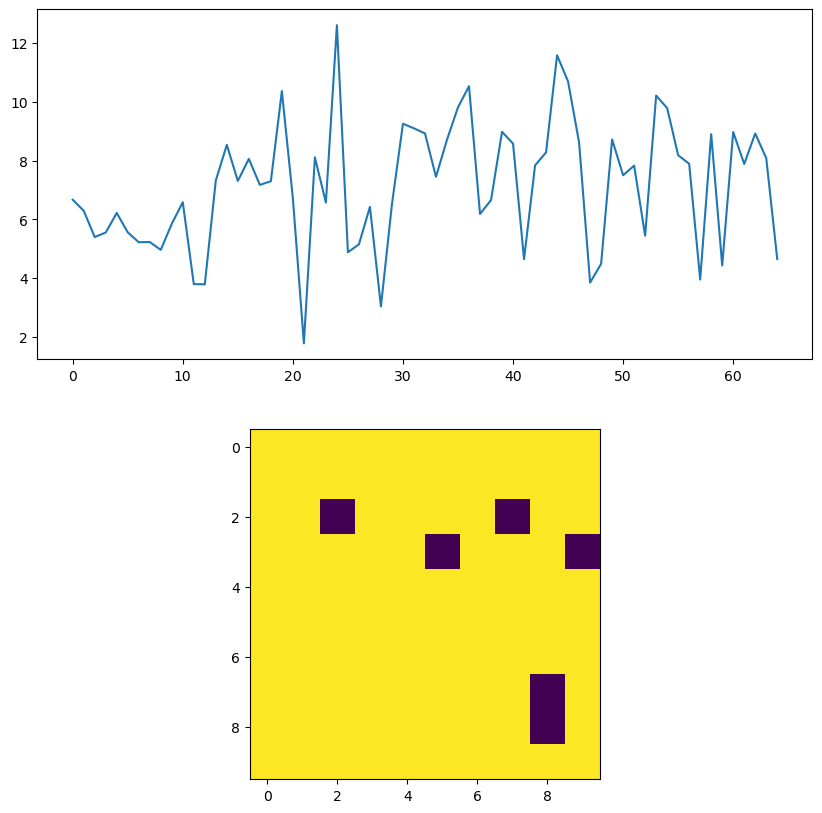

In [59]:
#subplots(2, 1)：创建一个包含多个子图的 Figure 对象。参数 2：表示子图的行数（垂直排列），参数 1：表示子图的列数（水平排列）
fig,ax = plt.subplots(2,1)
#参数 10：表示宽度（第一个参数），参数 10：表示高度（第二个参数）
fig.set_size_inches(10,10)
ax[0].plot(np.array(losses).mean(axis=0))
ax[1].imshow(grid)

In [60]:
%pip list

Package              Version
-------------------- ---------
ale-py               0.9.1
appnope              0.1.4
asttokens            3.0.0
backcall             0.2.0
Brotli               1.0.9
certifi              2024.8.30
cffi                 1.17.0
charset-normalizer   3.4.0
cloudpickle          3.1.0
comm                 0.2.2
contourpy            1.1.1
cycler               0.11.0
debugpy              1.8.5
decorator            5.1.1
executing            2.1.0
Farama-Notifications 0.0.4
filelock             3.16.1
fonttools            4.53.1
fsspec               2025.3.0
gym                  0.24.0
gym-notices          0.0.8
gym-super-mario-bros 7.3.0
gymnasium            0.29.1
h2                   4.1.0
hpack                4.0.0
hyperframe           6.0.1
idna                 3.10
imagecodecs          2023.1.23
imageio              2.35.1
importlib_metadata   8.5.0
importlib_resources  6.4.5
ipykernel            6.29.5
ipython              8.12.2
jax-jumpy            1.0.0
jed

In [61]:
%pip install magent2

Note: you may need to restart the kernel to use updated packages.


创建 magent 环境

In [62]:
import magent2
#from magent2.environments import battle_v4
import math
from scipy.spatial.distance import cityblock #从scipy导入 cityblock 距离函数，以计算网格上智能体之间的距离
map_size = 30
#magent2.GridWorld：用于创建基于网格的多智能体环境
env = magent2.GridWorld("battle", map_size=map_size) #以battle模式设置一个30*30 的网格环境
#env = battle_v4.env(render_mode='human')
#set_render_dir：magent2.GridWorld 类的一个方法，用于设置环境渲染结果的保存目录。
#"MAgent/build/render"：指定渲染结果保存的目录路径。设置这个目录后，在训练完成后可以查看游戏的渲染结果。
env.set_render_dir("MAgent/build/render") #设置训练后查看游戏的能力
#get_handles：magent2.GridWorld 类的一个方法，用于获取环境中不同团队的句柄。
team1, team2 = env.get_handles() #初始化两个团队对象

添加智能体

In [63]:
hid_layer = 25
in_size = 359  #神经网络输入层的神经元数量。这意味着输入到神经网络的数据维度为 359，也许是智能体的状态信息等。
act_space = 21
layers = [(in_size,hid_layer),(hid_layer,act_space)]
#2：推测是要生成两组参数向量，可能对应两个不同的深度 Q 网络（DQN）
#第二个参数:计算的是神经网络中需要学习的参数总数。
#in_size*hid_layer 是输入层到隐藏层的连接权重数量，
#hid_layer*act_space 是隐藏层到输出层的连接权重数量。
params = gen_params(2,in_size*hid_layer+hid_layer*act_space) #生成两个参数向量。用于参数化两个DQN
map_size = 30
width = height = map_size
n1 = n2 = 16 #设置每个团队智能体数量为 16
gap = 1 #设置每个团队智能体之间的初始间隙距离。
epochs = 100
replay_size = 70  #表示经验回放缓冲区的大小 
batch_size = 25


side1 = int(math.sqrt(n1)) * 2  #计算阵型边长（√16=4 → 8）
pos1 = [] #存储团队 1 智能体的位置
for x in range(width//2 - gap - side1, width//2 - gap - side1 + side1, 2): #循环将团队1的智能体放置在网格左侧  （起始值，结束值，步长 2）
    for y in range((height - side1)//2, (height - side1)//2 + side1, 2):
        pos1.append([x, y, 0])  #三维坐标（x,y,0）

side2 = int(math.sqrt(n2)) * 2
pos2 = []
for x in range(width//2 + gap, width//2 + gap + side2, 2): #循环将团队2的智能体放置在网格右侧
    for y in range((height - side2)//2, (height - side2)//2 + side2, 2):
        pos2.append([x, y, 0])
        
env.reset()
env.add_agents(team1, method="custom", pos=pos1) #使用刚刚创建的位置列表将团队1的智能体添加到表格
env.add_agents(team2, method="custom", pos=pos2)


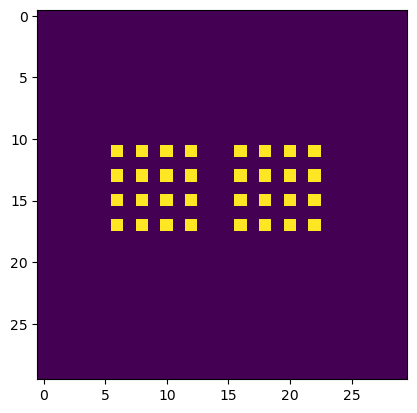

In [64]:
plt.imshow(env.get_global_minimap(30,30)[:,:,:].sum(axis=2))

查找邻居：以下代码来查找每个智能体邻域内的邻居，以计算平均场动作向量。

In [ ]:
def get_neighbors(j,pos_list,r=6): #给定pos_list 中所有智能体的位置[x,y]，返回智能体j 半径范围内的智能体的索引
    neighbors = []
    pos_j = pos_list[j]
    #enumerate:Python的内置函数，将一个可迭代对象（pos_list）组合为一个索引序列，同时返回索引和对应的元素
    #i：当前遍历到的智能体的索引
    #pos：当前遍历到的智能体的位置
    for i,pos in enumerate(pos_list):
        #如果当前遍历到的智能体的索引 i 等于目标智能体的索引 j，说明是目标智能体本身，需要跳过。
        if i == j:
            continue
        #曼哈顿距离计算（适用于网格移动规则）
        dist = cityblock(pos,pos_j) #实际使用二维距离（z坐标未参与计算）
        if dist < r:
            neighbors.append(i) #记录智能体索引
    return neighbors


使用env.get_pos(team1)得到团队 1 中每个智能体的坐标列表，然后将其与一个索引 j 传递给get_neighbors 函数，从而查找智能体 j 的邻居

In [66]:
get_neighbors(5,env.get_pos(team1))

[0, 1, 2, 4, 6, 7, 8, 9, 10, 13]

获取平均场动作向量

获取智能体周围邻居的平均场动作向量

get_mean_field 函数首先调用get_neighbors 函数获取智能体 j 的所有相邻智能体的坐标，然后使用这些坐标得到智能体的动作向量，将他们相加，并除以智能体的总数量以实现归一化。get_mean_field 函数期望得到相应的动作向量act_list（一个基于整数的动作列表），以pos_list和act_list中的索引匹配相同的智能体。此外，参数 r 是我们想要包含为邻居的智能体 j 周围网格正方形的半径，l 是动作空间大小，值为 21

In [ ]:
#a：表示动作的整数索引，这个索引指明了独热向量中值为 1 的位置
#l：独热向量的长度，默认值为 21
def get_onehot(a,l=21): #将动作的整数表示转换为独热向量表示
    x = torch.zeros(21)
    x[a] = 1
    return x

def get_scalar(v): #将动作的独热向量表示转换为整数表示
    return torch.argmax(v)


"""
j:目标智能体的索引
pos_list:智能体的位置列表，一般是 env.get_pos(team1) 的返回值。
act_list:智能体的动作列表，其中每个元素是对应智能体的动作的整数表示
r:查找邻居的半径
l:动作空间的大小
"""
def get_mean_field(j,pos_list,act_list,r=7,l=21): #获取智能体j的平均场动作向量，其中pos_list 是env.get_pos（team1）的返回值，1 是动作空间大小
    neighbors = get_neighbors(j,pos_list,r=r) #使用pos_list 查找智能体的所有邻居
    mean_field = torch.zeros(l)
    for k in neighbors:
        act_ = act_list[k]
        act = get_onehot(act_)
        mean_field += act #把邻居智能体 k 的动作独热向量累加到 mean_field 中
    tot = mean_field.sum()  #计算 mean_field 中所有元素的总和
    mean_field = mean_field / tot if tot > 0 else mean_field #确保不被0除
    return mean_field

得到一个观察值后，使用infer_acts 函数为每个智能体选着所有动作。它利用一个由 param 和 layers 参数化的平均场Q 函数对使用 softmax 策略的所有智能体动作进行抽样。infer_acts 函数接收并使用以下参数和变量（并附带每个参数的向量形状）

obs 是观察张量N✖️13✖️13✖️2

mean_fields 是包含每个智能体的所有平均场所动作的张量N✖️21

pos_list 是env.get_pos 返回的每个智能体的位置列表

acts 是每个智能体(N,)的整数表示的动作向量

num_iter是在动作抽样和策略更新之间交替的次数

temp 是 softmax 策略的温度，用于控制探索率。该函数返回一个元组

acts_是一个从策略抽样的整数动作向量(N,)

mean_fields_是每个智能体的平均场向量张量(N,21)

qvals 是每个智能体的每个动作的 Q 值张量(N,21)

In [ ]:
def infer_acts(obs,param,layers,pos_list,acts,act_space=21,num_iter=5,temp=0.5):
    N = acts.shape[0] #获取智能体的数量
    mean_fields = torch.zeros(N,act_space)
    acts_ = acts.clone() #复制动作向量，以免改变原始值
    qvals = torch.zeros(N,act_space)

    for i in range(num_iter): #交替几次，以在动作上收敛
        for j in range(N): #循环遍历智能体并计算他们的邻域平均场动作向量。
            mean_fields[j] = get_mean_field(j,pos_list,acts_)

        #策略网络前向传播
        for j in range(N): #使用平均场动作和状态计算 Q 值，并使用 softmax 策略选择动作
            #将环境状态与群体行为特征融合
            # torch.cat：PyTorch 中的一个函数，用于将多个张量沿着指定的维度进行拼接
            state = torch.cat((obs[j].flatten(),mean_fields[j]))
            qs = qfunc(state.detach(),param,layers=layers)  #阻断平均场梯度反传
            qvals[j,:] = qs[:] #计算得到的 Q 值存储在 qvals 张量的第 j 行
            acts_[j] = softmax_policy(qs.detach(),temp=temp)
    return acts_, mean_fields, qvals

def init_mean_field(N,act_space=21):  #随机初始化平均场动作向量
    #torch.abs(...)：取随机张量的绝对值，确保元素为非负数
    mean_fields = torch.abs(torch.rand(N,act_space))
    for i in range(mean_fields.shape[0]):
        mean_fields[i] = mean_fields[i] / mean_fields[i].sum()
    return mean_fields

训练函数

train 函数使用经验回放缓冲器中存储的经验来训练单个神经网络，它有以下输入和输出：

输入：

batch_size(int);

replay,元组列表(obs_1_small,acts_1,rewards1,act_means1,qnext1);

param(vector),神经网络参数向量

layers(list),包含神经网络的形状

J(int),团队中智能体的数量

gamma([0,1]内的浮点数),贴现因子

lr(float),SGD 的学习率

返回值：

loss(float)

In [ ]:
def train(batch_size,replay,param,layers,J=64,gamma=0.5,lr=0.001):
    ids = np.random.randint(low=0,high=len(replay),size=batch_size)  #生成一个随机的索引列表来取经验回放的子集
    exps = [replay[idx] for idx in ids]  #取经验回放缓冲器的子集来得到一小批数据
    losses = []
    jobs = torch.stack([ex[0] for ex in exps]).detach() #将小批次中的所有状态收集到一个张量中
    jacts = torch.stack([ex[1] for ex in exps]).detach()  #将小批次中的所有动作收集到一个张量中
    jrewards = torch.stack([ex[2] for ex in exps]).detach() #将小批次中的所有奖励收集到一个张量中
    jmeans = torch.stack([ex[3] for ex in exps]).detach()  #将小批次中的所有平均场动作收集到一个张量中
    vs = torch.stack([ex[4] for ex in exps]).detach()  ##将小批次中的所有状态值收集到一个张量中
    qs = []
    for h in range(batch_size): #循环遍历小批次中的每天经验
        state = torch.cat((jobs[h].flatten(),jmeans[h]))
        qs.append(qfunc(state.detach(),param,layers=layers))  #为回放中的每条经验计算 Q 值
    qvals = torch.stack(qs)  #存储每个样本的 Q 值
    target = qvals.clone().detach()
    target[:,jacts] = jrewards + gamma * torch.max(vs,dim=1)[0] #计算目标Q值
    loss = torch.sum(torch.pow(qvals - target.detach(),2))
    losses.append(loss.detach().item())
    loss.backward()
    #SGD
    with torch.no_grad():   #随机梯度下降
        param = param - lr * param.grad
    param.requires_grad = True
    return np.array(losses).mean()

 初始化动作

 以下代码中的变量记录每个智能体的动作（整数）、平均场动作向量、奖励和下一个状态的 Q 值，以便能够将这些信息打包到经验中，并将他们添加到经验回放系统中

In [ ]:
N1 = env.get_num(team1) #存储每个团队智能体的数量
N2 = env.get_num(team2)
step_ct = 0  #用于记录环境交互的步数，初始化为 0。
acts_1 = torch.randint(low=0,high=act_space,size=(N1,)) #初始化所有智能体的动作
acts_2 = torch.randint(low=0,high=act_space,size=(N2,))

replay1 = deque(maxlen=replay_size) #使用deque数据结果创建回放缓冲器
replay2 = deque(maxlen=replay_size)

qnext1 = torch.zeros(N1) #创建张量，以存储Q(s')值，其中s'为下一个状态
qnext2 = torch.zeros(N2)

act_means1 = init_mean_field(N1,act_space)  #初始化每个智能体的平均场
act_means2 = init_mean_field(N2,act_space)

rewards1 = torch.zeros(N1) #创建张量，以存储每个智能体的奖励
rewards2 = torch.zeros(N2)

losses1 = []
losses2 = []

执行动作并将经验添加到回放缓冲器中

team_step 函数是主训练循环所在位置，使用他从环境中收集所有数据，并运行DQN 来决定采取哪些动作。add_to_replay 函数接收观察张量、动作张量、奖励张量、平均场动作张量和下一个状态的 Q 值张量，并将每个智能体经验单独添加到回放缓冲器中。

In [ ]:
def team_step(team,param,acts,layers):
    obs = env.get_observation(team) #从团队1获取观察张量，他是一个形状为 16*13*13*7 的张量
    ids = env.get_agent_id(team) #获取仍然存活的智能体的索引列表
    obs_small = torch.from_numpy(obs[0][:,:,:,[1,4]]) #取观察张量的子集来只获得智能体位置
    agent_pos = env.get_pos(team) #获取一个团队中每个智能体的坐标列表
    acts, act_means, qvals = infer_acts(obs_small,\
                                       param,layers,agent_pos,acts) #使用DQN 为每个智能体决定采取哪个动作
    return acts, act_means, qvals, obs_small, ids

def add_to_replay(replay,obs_small, acts,rewards,act_means,qnext): #将每个智能体的经验分别单独添加到回放缓冲器中
    for j in range(rewards.shape[0]): #循环遍历每个智能体
        exp = (obs_small[j], acts[j],rewards[j],act_means[j],qnext[j])
        replay.append(exp)
        
    return replay

In [72]:
for i in range(epochs):
    done = False
    while not done: #A
        acts_1, act_means1, qvals1, obs_small_1, ids_1 = \
            team_step(team1,params[0],acts_1,layers) #B
        env.set_action(team1, acts_1.detach().numpy().astype(np.int32)) #C

        acts_2, act_means2, qvals2, obs_small_2, ids_2 = \
            team_step(team2,params[0],acts_2,layers)
        env.set_action(team2, acts_2.detach().numpy().astype(np.int32))

        done = env.step() #D

        _, _, qnext1, _, ids_1 = team_step(team1,params[0],acts_1,layers) #E
        _, _, qnext2, _, ids_2 = team_step(team2,params[0],acts_2,layers)

        env.render() #F

        rewards1 = torch.from_numpy(env.get_reward(team1)).float() #G
        rewards2 = torch.from_numpy(env.get_reward(team2)).float()
        #
        #
        #
        replay1 = add_to_replay(replay1, obs_small_1, acts_1,rewards1,act_means1,qnext1) #A
        replay2 = add_to_replay(replay2, obs_small_2, acts_2,rewards2,act_means2,qnext2)     
        shuffle(replay1) #B
        shuffle(replay2)
        
        ids_1_ = list(zip(np.arange(ids_1.shape[0]),ids_1)) #C
        ids_2_ = list(zip(np.arange(ids_2.shape[0]),ids_2))
        
        env.clear_dead() #D
        
        ids_1  = env.get_agent_id(team1) #E
        ids_2  = env.get_agent_id(team2)
        
        ids_1_ = [i for (i,j) in ids_1_ if j in ids_1] #F
        ids_2_ = [i for (i,j) in ids_2_ if j in ids_2]
        
        acts_1 = acts_1[ids_1_] #G
        acts_2 = acts_2[ids_2_]
        
        step_ct += 1
        if step_ct > 250:
            break
            
        if len(replay1) > batch_size and len(replay2) > batch_size: #H
            loss1 = train(batch_size,replay1,params[0],layers=layers,J=N1)
            loss2 = train(batch_size,replay2,params[1],layers=layers,J=N1)
            losses1.append(loss1)
            losses2.append(loss2)